## 911 Calls project
In this project I will analyze some 911 call data from [Kaggle](https://www.kaggle.com/mchirico/montcoalert). The data contains the following fields:

* lat : String variable, Latitude
* lng: String variable, Longitude
* desc: String variable, Description of the Emergency Call
* zip: String variable, Zipcode
* title: String variable, Title
* timeStamp: String variable, YYYY-MM-DD HH:MM:SS
* twp: String variable, Township
* addr: String variable, Address
* e: String variable, Dummy variable (always 1)



## Table Of Contents:
* [1. Obtain data](#1)
* [2. Data cleaning](#2)
* [3. Data exploration](#3)
* [4. Modeling](#4)

## 1. Obtain the data <a class="anchor" id="1"></a>
I will load the data and import some importana libraries.
* The file "us_zipcode.csv" is originally from https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [21]:
df = pd.read_csv("data/911.csv")
df.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:40:00,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:40:00,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 17:40:00,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 17:40:01,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 17:40:01,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


## Data cleaning <a class="anchor" id="2"></a>

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99492 entries, 0 to 99491
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lat        99492 non-null  float64
 1   lng        99492 non-null  float64
 2   desc       99492 non-null  object 
 3   zip        86637 non-null  float64
 4   title      99492 non-null  object 
 5   timeStamp  99492 non-null  object 
 6   twp        99449 non-null  object 
 7   addr       98973 non-null  object 
 8   e          99492 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 6.8+ MB


I will make an extra column of the reason of the call (it will help with grouping thw types of the calls)

In [23]:
def StationMiner(x):
    try:
        return (re.sub('[:]', '', x.split('Station')[1].split(';')[0])).strip()
    except:
        return np.nan   
    
df['Station']=df['desc'].apply(lambda x: StationMiner(x))
df["Reason"] = df.title.apply(lambda x: x.split(":")[0])
df["Issue"] = df.title.apply(lambda x: x.split(":")[1].strip())

df["timeStamp"] = pd.to_datetime(df.timeStamp)
df["Hour"] = df.timeStamp.apply(lambda x: x.hour)
df["month"] = df.timeStamp.apply(lambda x: x.month)
df["day_of_week"] = df.timeStamp.apply(lambda x: x.dayofweek) 

df.drop(columns=['desc','title','addr','e'],inplace=True)

#Just organizing the columns in a reasonable oreder
df = df[['lat','lng', 'zip', 'twp','Station', 'Reason','Issue','timeStamp','Hour','month','day_of_week']]
df.info()
99492-86637

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99492 entries, 0 to 99491
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   lat          99492 non-null  float64       
 1   lng          99492 non-null  float64       
 2   zip          86637 non-null  float64       
 3   twp          99449 non-null  object        
 4   Station      63797 non-null  object        
 5   Reason       99492 non-null  object        
 6   Issue        99492 non-null  object        
 7   timeStamp    99492 non-null  datetime64[ns]
 8   Hour         99492 non-null  int64         
 9   month        99492 non-null  int64         
 10  day_of_week  99492 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 8.3+ MB


12855

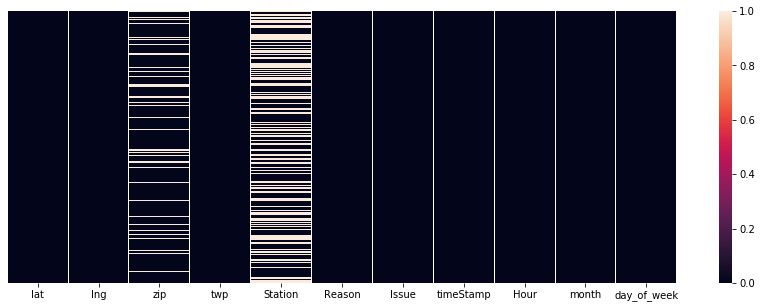

In [24]:
plt.figure(figsize=(15,5))
sns.heatmap(df.isnull(),yticklabels=False)

We have some of zip data that missing, but we have the latitude and longitude of every call - so I
need to mine the data from source like google/yandex and other geocoder resources - but the API is not for free.
After a sort search on the web i find an geocoder provider with 15,000 monthly limit (and our missing data is only 12,855!) - 
http://more.stevemorse.org/latlonbatch2.html?direction=reverse

In [25]:
# Remove all duplicates for lat lng.
LatLng=df[df['zip'].isna()][['lat','lng']].drop_duplicates()
# Convert them to list to be readable by geocoder
LatLng.to_csv('./data//LatLng.csv',index=False)
LL=LatLng.values.tolist()

My web scraping skills are not at this level so i used Monzenda for the intergration of CSV files.

In [26]:
LatLngAddress = pd.read_csv('./data//LatLngAddress.csv')
LLZ = LatLngAddress[['lat','lng','zipcode']]
df['idx'] = df.index
df1 = df[df['zip'].isna()]
df2 = df[~df['zip'].isna()]
df1 = pd.merge(left=df1,right=LLZ,how='left',on=['lat','lng'])
df1['zip'] = df1['zipcode']
df1.drop(columns=['zipcode'],inplace=True)
df1 = df1.append(df2,sort=False).set_index('idx').sort_index()
df1['zip'] = df1['zip'].astype('int32')
df1.info()
df = df1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99492 entries, 0 to 99491
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   lat          99492 non-null  float64       
 1   lng          99492 non-null  float64       
 2   zip          99492 non-null  int32         
 3   twp          99449 non-null  object        
 4   Station      63797 non-null  object        
 5   Reason       99492 non-null  object        
 6   Issue        99492 non-null  object        
 7   timeStamp    99492 non-null  datetime64[ns]
 8   Hour         99492 non-null  int64         
 9   month        99492 non-null  int64         
 10  day_of_week  99492 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(3), object(4)
memory usage: 8.7+ MB


In [27]:
ReasonByStation = df.groupby("Reason")["Station"].count()
print(ReasonByStation)
print(len(df) - ReasonByStation.sum())
print(df.Station.isnull().sum())

Reason
EMS        48877
Fire       14920
Traffic        0
Name: Station, dtype: int64
35695
35695


So when the reason of the call was traffic there was not one documentation about the station.
All the missing stations was referred to Traffic.


In [49]:
dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df["day_of_week_str"] = df.day_of_week.map(dmap)

## Data exploration <a class="anchor" id="3"></a>

Text(0.5, 1.05, 'Incidents per month/day')

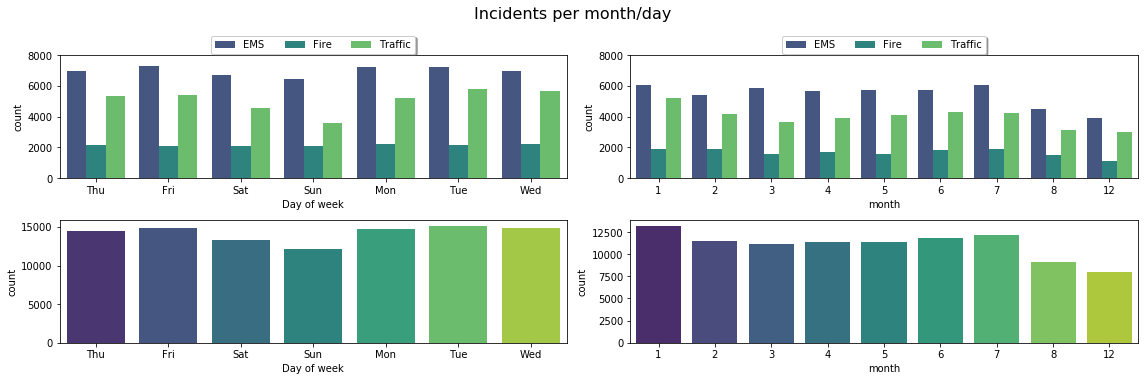

In [81]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,5))
ax1 = sns.countplot(data=df, x="day_of_week_str", hue="Reason", palette="viridis",ax=axs[0,0])
ax1.set_ylim(0,8000)
ax1.set_xlabel("Day of week")
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=3, fancybox=True, shadow=True)

ax2 = sns.countplot(data=df, x="month", hue="Reason", palette="viridis",ax=axs[0,1])
ax2.set_ylim(0,8000)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=3, fancybox=True, shadow=True)

ax3 = sns.countplot(data=df, x="day_of_week_str", palette="viridis",ax=axs[1,0])
ax3.set_xlabel("Day of week")
ax4 = sns.countplot(data=df, x="month", palette="viridis",ax=axs[1,1])

plt.tight_layout()
fig.suptitle('Incidents per month/day', fontsize=16,y=1.05)


## Modeling <a class="anchor" id="4"></a>